## Make a simple synthetic dataset to test hierarchical merge in FOF algorithm

#### the idea is this: 

* after the local FOF stage, each partition reports the particles it holds in the overlap region
* do a reduceByKey or treeAggregate of some sort to collect the groups belonging to the same particles
* produce a mapping of $G -> G_1$ and distribute to all hosts in form of broadcast lookup table

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

import sys
sys.setrecursionlimit(sys.getrecursionlimit()*10)
import matplotlib.patches as patches

plt.style.use('bmh')

/Users/rokstar/miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:486: UserWarning: matplotlibrc text.usetex option can not be used unless TeX-3.1415 or later is installed on your system
  'installed on your system') % tex_req)
/Users/rokstar/miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:493: UserWarning: matplotlibrc text.usetex can not be used with *Agg backend unless dvipng-1.5 or later is installed on your system
  warnings.warn('matplotlibrc text.usetex can not be used with *Agg '
/Users/rokstar/miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:508: UserWarning: matplotlibrc text.usetex can not be used unless ghostscript-7.07 or later is installed on your system
  'installed on your system') % gs_req)


In [2]:
import spark_fof
import spark_fof_c
import fof

In [3]:
def plot_rectangle(rec, ax=None):
    if ax is None: 
        ax = plt.subplot(aspect='equal')
    
    if isinstance(rec, (list, tuple)):
        for r in rec: 
            plot_rectangle(r,ax)
    
    else:
        size = (rec.maxes-rec.mins)
        ax.add_patch(patches.Rectangle(rec.mins, size[0], size[1], fill=False, zorder=-1))

## Set up data

In [4]:
# create the arrays
pdt = np.dtype([('pos','f4', 3), ('iGroup', 'i4'), ('iOrder', 'i4')])
pdt_tipsy = np.dtype({'names': ("mass", "x", "y", "z", "vx", "vy", "vz", "eps", "phi"),
                                  'formats': ('f','f','f','f','f','f','f','f','f')})

pdt_tipsy = np.dtype([('mass', 'f4'),('pos', 'f4', 3),('vel', 'f4', 3), ('eps', 'f4'), ('phi', 'f4')])
# nps = 1000000
# ngs = 1
# particles = np.zeros(nps, dtype=pdt)
# done_ps = 0
# #centers = np.random.rand(ngs,3)*1.7 - 0.85
# centers = np.array([0,0,0]).reshape(1,3)
# for group, center in zip(range(ngs), centers): 
#     print group, center
#     group_ps = nps/ngs
#     if nps - (done_ps + group_ps) < group_ps:
#         group_ps = nps - done_ps 
#     particles['pos'][done_ps:done_ps+group_ps] = \
#         np.random.multivariate_normal(center, [[.5,0,0],[0,.5,0],[0,0,.5]], group_ps)
#     done_ps += group_ps
   
# particles['iOrder'] = range(nps)

## Start Spark

In [5]:
import findspark
findspark.init()

In [6]:
import os
os.environ['SPARK_CONF_DIR'] = './conf'
os.environ['SPARK_DRIVER_MEMORY'] = '4G'

In [7]:
import pyspark
from pyspark import SparkContext, SparkConf
import pynbody

In [8]:
conf = SparkConf()

In [9]:
conf.set('spark.python.profile', 'true')
conf.set('spark.executor.memory', '3G')
conf.set('spark.driver.memory', '4G')


In [10]:
sc = SparkContext(master='local[*]', conf=conf, batchSize=0)

In [11]:
sc.addPyFile('spark_fof.py')
sc.addPyFile('spark_util.py')
sc.addPyFile('spark_fof_c.pyx')
sc.addPyFile('spark_fof_c.c')
sc.addPyFile('spark_fof_c.so')
sc.addPyFile('fof.so')

## Set up the domains

In [12]:
N = 1
tau = 7.8125e-4
mins = np.array([-.5,-.5,-.5], dtype=np.float)
maxs= np.array([.5,.5,.5], dtype=np.float)
domain_containers = spark_fof.setup_domain(N,tau,maxs,mins)

In [13]:
domain_containers

[<DomainRectangle [(-0.5, 0.0), (-0.5, 0.0), (-0.5, 0.0)]>,
 <DomainRectangle [(0.0, 0.5), (-0.5, 0.0), (-0.5, 0.0)]>,
 <DomainRectangle [(-0.5, 0.0), (0.0, 0.5), (-0.5, 0.0)]>,
 <DomainRectangle [(0.0, 0.5), (0.0, 0.5), (-0.5, 0.0)]>,
 <DomainRectangle [(-0.5, 0.0), (-0.5, 0.0), (0.0, 0.5)]>,
 <DomainRectangle [(0.0, 0.5), (-0.5, 0.0), (0.0, 0.5)]>,
 <DomainRectangle [(-0.5, 0.0), (0.0, 0.5), (0.0, 0.5)]>,
 <DomainRectangle [(0.0, 0.5), (0.0, 0.5), (0.0, 0.5)]>]

NameError: name 's' is not defined

/Users/rokstar/miniconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


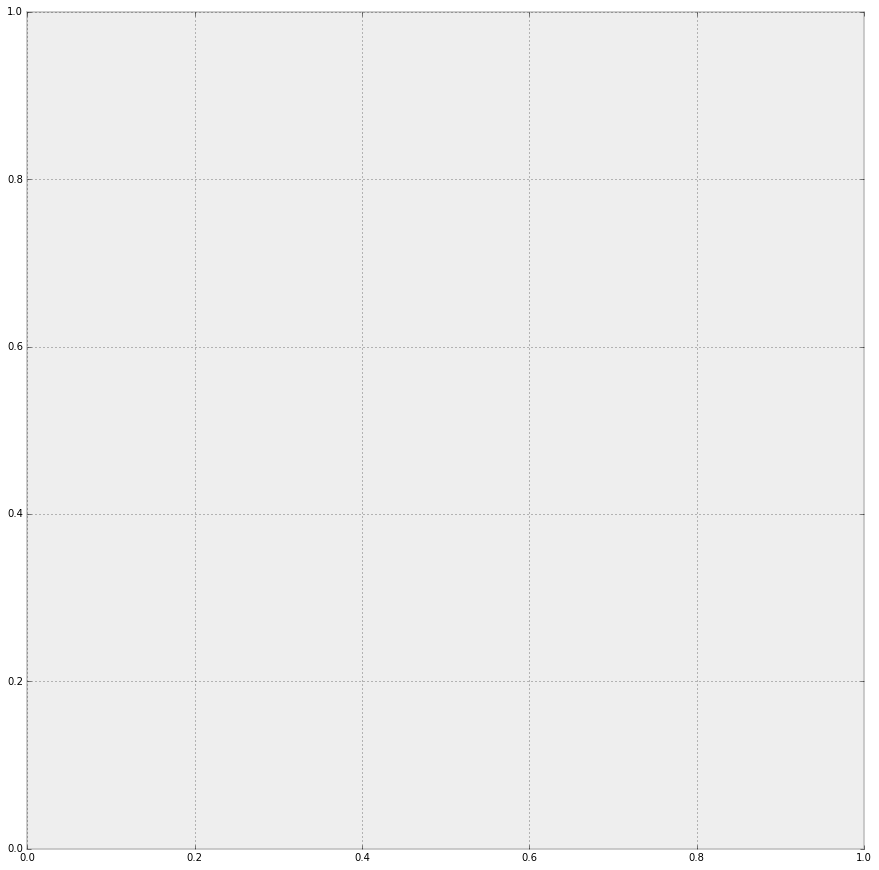

In [14]:
f, ax = plt.subplots(subplot_kw={'aspect':'equal'}, figsize=(15,15))
pynbody.plot.image(s.d, width=1, units = 'Msol Mpc^-2', cmap=plt.cm.Greys, show_cbar=False, subplot=ax)
#plot_rectangle(domain_containers[0].bufferRectangle, ax=ax)
for p in particles[::1000000]: 
    plot_rectangle(domain_containers[spark_fof.get_bin_cython(p['pos'],2**N, np.array(mins), np.array(maxs))], ax=ax)
    plot_rectangle(domain_containers[spark_fof.get_bin_cython(p['pos'], 2**N, np.array(mins),np.array(maxs))].bufferRectangle, ax=ax)
    ax.plot(p['pos'][0], p['pos'][1], '.')
plt.draw()
ax.set_xlim(-.5,.5)
ax.set_ylim(-.5,.5)

### Make the base RDD

In [15]:
def convert_to_fof_particle(s): 
    p_arr = np.fromstring(s, pdt_tipsy)
    
    new_arr = np.zeros(len(p_arr), dtype=pdt)
    new_arr['pos'] = p_arr['pos']
    
    return new_arr

In [16]:
def set_particle_IDs((p,i)): 
    p['iOrder'] = i
    return p

In [26]:
p_rdd = sc.binaryRecords('euclid256.nat_no_header', pdt_tipsy.itemsize*2048)\
          .flatMap(convert_to_fof_particle).zipWithIndex().map(set_particle_IDs)

In [27]:
%time p_rdd.count()

CPU times: user 26.1 ms, sys: 3.79 ms, total: 29.9 ms
Wall time: 19.2 s


16777216

In [28]:
sc.show_profiles()

Profile of RDD<id=12>
         16875952 function calls in 12.427 seconds

   Ordered by: internal time, cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
 16777234    8.065    0.000    9.145    0.000 rdd.py:2080(<genexpr>)
       18    3.279    0.182   12.424    0.690 {sum}
    16402    0.492    0.000    0.492    0.000 {method 'read' of 'file' objects}
     8192    0.315    0.000    0.473    0.000 <ipython-input-15-1d6e4fba05cc>:1(convert_to_fof_particle)
     8192    0.088    0.000    0.088    0.000 {numpy.core.multiarray.fromstring}
     8192    0.068    0.000    0.068    0.000 {numpy.core.multiarray.zeros}
     8210    0.050    0.000    0.585    0.000 serializers.py:155(_read_with_length)
     8210    0.028    0.000    0.089    0.000 serializers.py:542(read_int)
     8210    0.023    0.000    0.608    0.000 serializers.py:136(load_stream)
     8210    0.008    0.000    0.008    0.000 {_struct.unpack}
    16420    0.005    0.000    0.005    0.00

In [ ]:
ps = p_rdd.collect()

In [ ]:
particles = np.from

In [19]:
fof.run(np.fromiter(ps,pdt), tau)

7251094

In [33]:
%time p_rdd.count()

CPU times: user 20 ms, sys: 3.37 ms, total: 23.3 ms
Wall time: 4.54 s


16777216

### Partition particles into domains and set the partition part of local group ID

In [21]:
p_rdd.mapPartitions(lambda particles: spark_fof.partition_particles_cython(particles, domain_containers, tau, mins, maxs)).count()

16806108

In [22]:
sc.show_profiles()

Profile of RDD<id=2>
         16974256 function calls in 12.994 seconds

   Ordered by: internal time, cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
 16777234    8.358    0.000    9.646    0.000 rdd.py:2080(<genexpr>)
       18    3.346    0.186   12.992    0.722 {sum}
    32786    0.565    0.000    0.565    0.000 {method 'read' of 'file' objects}
    16384    0.343    0.000    0.538    0.000 <ipython-input-14-1d6e4fba05cc>:1(convert_to_fof_particle)
    16384    0.103    0.000    0.103    0.000 {numpy.core.multiarray.zeros}
    16384    0.088    0.000    0.088    0.000 {numpy.core.multiarray.fromstring}
    16402    0.079    0.000    0.713    0.000 serializers.py:155(_read_with_length)
    16402    0.044    0.000    0.091    0.000 serializers.py:542(read_int)
    16402    0.037    0.000    0.750    0.000 serializers.py:136(load_stream)
    16402    0.014    0.000    0.014    0.000 {_struct.unpack}
    32804    0.009    0.000    0.009    0.000

In [41]:
# partitioning duplicates the particles that are located in the boundary regions
part_rdd = (p_rdd.mapPartitions(lambda particles: spark_fof.partition_particles_cython(particles, domain_containers, tau, mins, maxs))
                 .partitionBy(len(domain_containers))
                 .values())

In [42]:
%time part_rdd.count()

CPU times: user 465 ms, sys: 47.7 ms, total: 513 ms
Wall time: 4min 1s


17053662

In [43]:
sc.show_profiles()

Profile of RDD<id=34>
         171751637 function calls (171751565 primitive calls) in 802.075 seconds

   Ordered by: internal time, cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     2656  194.103    0.073  194.103    0.073 {cPickle.dumps}
     5330  153.610    0.029  800.167    0.150 rdd.py:1697(add_shuffle_key)
 16777216  134.370    0.000  267.832    0.000 spark_fof_c.pyx:53(rect_buffer_zone_cython)
 33554432  133.463    0.000  133.463    0.000 spark_fof_c.pyx:104(in_rectangle_cython)
 18624424   77.637    0.000   77.637    0.000 spark_fof_c.pyx:19(get_bin_cython)
 16777216   37.908    0.000   37.908    0.000 <ipython-input-14-ca5787da3fcb>:1(set_particle_IDs)
 17053662   33.047    0.000   47.134    0.000 rdd.py:61(portable_hash)
 16777234   14.425    0.000   16.325    0.000 rdd.py:2084(func)
 17053666   10.956    0.000   10.956    0.000 {isinstance}
 17053662    3.131    0.000    3.131    0.000 {hash}
 17053662    3.041    0.000    3.041 

### Run the local FOF

In [93]:
from spark_util import spark_cython

In [94]:
import fof

In [95]:
def run_local_fof(index, particle_iter, tau): 
    part_arr = np.fromiter(particle_iter, pdt)
    if len(part_arr)>0:
        fof.run(part_arr, tau)
    return part_arr

def encode_gid(pid, cid, bits=32):
    if bits == 32: 
        res = np.int64(int(np.binary_repr(pid,width=32)+np.binary_repr(cid,width=32),2))
    elif bits == 16:
        res = np.int32(int(np.binary_repr(pid,width=16)+np.binary_repr(cid,width=16),2))
    else: 
        raise RuntimeError('Group encoding must use either 16 or 32 bit integers')
    return res

def set_group_id(partition_index, particle_iter):
    part_arr = np.fromiter(particle_iter, pdt)
    for i in range(len(part_arr)):
        #p = np.copy(part_arr[i])
        gid = part_arr['iGroup'][i]
        part_arr['iGroup'][i] = int(bin((partition_index<<16) | gid), 2)
    #    res = int(bin((partition_index<<16) | gid),2)
     #   part_arr['iGroup'][i] = res
    #    print res, partition_index, gid, spark_fof.encode_gid(partition_index, gid, 16)
   # print part_arr[:10]
    return part_arr

In [96]:
fof_rdd = part_rdd.mapPartitionsWithIndex(lambda index, particles: run_local_fof(index, particles, tau))\
                  .mapPartitionsWithIndex(set_group_id).cache()

### Group Merging stage

In [97]:
fof_analyzer = spark_fof.FOFAnalyzer(sc, N, tau, fof_rdd, [-.5,-.5,-.5], [.5,.5,.5])

In [98]:
%time fof_rdd.count()

CPU times: user 270 ms, sys: 10 ms, total: 280 ms
Wall time: 39.4 s


17053662

In [101]:
sc.show_profiles()

Profile of RDD<id=59>
         480156 function calls (480138 primitive calls) in 3.839 seconds

   Ordered by: internal time, cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    32796    2.423    0.000    2.423    0.000 {method 'read' of 'file' objects}
     1704    0.477    0.000    3.688    0.002 rdd.py:1697(add_shuffle_key)
   114688    0.223    0.000    0.223    0.000 spark_fof_c.pyx:19(get_bin_cython)
      843    0.211    0.000    0.211    0.000 {cPickle.dumps}
     3372    0.138    0.000    0.138    0.000 {method 'write' of 'file' objects}
    16384    0.061    0.000    0.061    0.000 {numpy.core.multiarray.array}
    16402    0.058    0.000    2.526    0.000 serializers.py:155(_read_with_length)
    16384    0.047    0.000    0.083    0.000 spark_fof_c.pyx:53(rect_buffer_zone_cython)
    33115    0.037    0.000    0.060    0.000 rdd.py:61(portable_hash)
    32768    0.035    0.000    0.035    0.000 spark_fof_c.pyx:104(in_rectangle_cython

In [102]:
merged_rdd = fof_analyzer.merge_groups(0)

In [103]:
merged = merged_rdd.collect()

In [104]:
merged_arr = np.fromiter(merged, pdt)

In [105]:
groups = np.unique(merged_arr['iGroup'])

In [106]:
len(groups)

101480

In [107]:
sc.show_profiles()

Profile of RDD<id=78>
         86054557 function calls in 145.013 seconds

   Ordered by: internal time, cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
 17053662   45.303    0.000   80.391    0.000 spark_fof_c.pyx:53(rect_buffer_zone_cython)
 34107324   35.089    0.000   35.089    0.000 spark_fof_c.pyx:104(in_rectangle_cython)
 17053662   33.159    0.000  118.694    0.000 spark_fof.py:382(in_buffer_zone)
   308380   10.553    0.000  140.032    0.000 spark_fof.py:252(get_buffer_particles)
    13695    9.310    0.001    9.310    0.001 {cPickle.loads}
 17053662    5.144    0.000   85.535    0.000 {spark_fof_c.rect_buffer_zone_cython}
     4819    3.481    0.001    3.481    0.001 {cPickle.dumps}
    27902    1.057    0.000    1.057    0.000 {method 'read' of 'file' objects}
   307868    0.863    0.000    0.863    0.000 spark_fof.py:265(pid_gid)
      512    0.513    0.001  144.989    0.283 serializers.py:259(dump_stream)
    14207    0.148    0.000

In [ ]:
f, axs = plt.subplots(1,2, subplot_kw={'aspect':'equal'}, figsize=(12,12))
for group in groups: 
    inds = np.where(merged_arr['iGroup'] == group)[0]
    print group, len(inds)
    axs[0].plot(merged_arr['pos'][inds,1], merged_arr['pos'][inds,0], ',')
    axs[1].plot(merged_arr['pos'][inds,2], merged_arr['pos'][inds,0], ',')
for ax in axs:
    ax.set_xlim(-1,1); ax.set_ylim(-1,1)

In [ ]:
sc.show_profiles()

In [20]:
%time fof.run(particles, tau)

NameError: name 'particles' is not defined